<a href="https://colab.research.google.com/github/deepakri201/MIDRC_colab/blob/main/MIDRC_df_plotting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Parameterization

In [1]:
!gcloud config set project  bwh-midrc-rapid-res-1655321320

Updated property [core/project].


In [2]:
from google.colab import auth
auth.authenticate_user()

In [3]:
# project_name = "bwh-midrc-rapid-res-1655321320"
# bucket_name = "midrc-analysis-bwh"
# bucket_path = "bpr-results"
# table_name = "radiomics_features"

project_name = "bwh-midrc-rapid-res-1655321320"
# bucket_name = "midrc-analysis-bwh"
bucket_name = "midrc-analysis-bwh-dk"
# bucket_path = "bpr-results"
bucket_path = "bpr-results/"

dataset_table_id = "midrc_dicom_us" # This already exists 
table_view_id_name = "ct_limited_open_a1_r1_dk"
# table_id = "bwh-midrc-rapid-res-1655321320.midrc_dicom_us.ct_limited_open_a1_r1_dk"

# Tables with ohif urls 
quantitative_measurements_features_table_with_ohif = 'quantitative_measurements_features_dk_with_ohif'
qualitative_measurements_regions_table_with_ohif = 'qualitative_measurements_regions_dk_with_ohif'
qualitative_measurements_landmarks_table_with_ohif = 'qualitative_measurements_landmarks_dk_with_ohif'

radiomics_table_name = "radiomics_features_dk"

# Environment setup

In [7]:
import matplotlib.pyplot as plt
from matplotlib import transforms
from matplotlib.colors import ListedColormap
import seaborn as sb 
import pandas as pd 
import numpy as np
from google.cloud import bigquery

# Queries

In [5]:
# %%bigquery ct_limited_open_a1_r1 --project=bwh-midrc-rapid-res-1655321320

# WITH
#   nlst_instances_per_series AS (
#     SELECT
#       DISTINCT(StudyInstanceUID),
#       SeriesInstanceUID,
#       COUNT(DISTINCT(SOPInstanceUID)) AS num_instances,
#       COUNT(DISTINCT(ARRAY_TO_STRING(ImagePositionPatient,"/"))) AS position_count,
#       COUNT(DISTINCT(ARRAY_TO_STRING(ImageOrientationPatient,"/"))) AS orientation_count,
#       MIN(SAFE_CAST(SliceThickness AS float64)) AS min_SliceThickness,
#       MAX(SAFE_CAST(SliceThickness AS float64)) AS max_SliceThickness,
#       MIN(SAFE_CAST(ImagePositionPatient[SAFE_OFFSET(2)] AS float64)) as min_SliceLocation, 
#       MAX(SAFE_CAST(ImagePositionPatient[SAFE_OFFSET(2)] AS float64)) as max_SliceLocation,
#       STRING_AGG(DISTINCT(SAFE_CAST("LOCALIZER" IN UNNEST(ImageType) AS string)),"") AS has_localizer
#     FROM
#       bwh-midrc-rapid-res-1655321320.midrc_dicom_us.dicom_all
#     WHERE
#       (collection_id = "Open-R1" or collection_id = "Open-A1") and Modality = "CT"
#     GROUP BY
#       StudyInstanceUID,
#       SeriesInstanceUID
#       ), 
#   nlst_values_per_series AS (
#     SELECT 
#     ANY_VALUE(dicom_all.PatientID) AS PatientID,
#     dicom_all.SeriesInstanceUID,
#     ANY_VALUE(nlst_instances_per_series.num_instances) AS num_instances,
#     ANY_VALUE(nlst_instances_per_series.max_SliceThickness) AS SliceThickness,
#     ANY_VALUE((nlst_instances_per_series.max_SliceLocation - nlst_instances_per_series.min_SliceLocation)) AS PatientHeightScanned
#   FROM
#     bwh-midrc-rapid-res-1655321320.midrc_dicom_us.dicom_all AS dicom_all
#   JOIN
#     nlst_instances_per_series
#   ON
#     dicom_all.SeriesInstanceUID = nlst_instances_per_series.SeriesInstanceUID
#   WHERE
#     min_SliceThickness >= 1.5 
#     AND max_SliceThickness <= 3.5 
#     AND nlst_instances_per_series.num_instances > 100
#     AND nlst_instances_per_series.num_instances/nlst_instances_per_series.position_count = 1
#     AND nlst_instances_per_series.orientation_count = 1
#     AND has_localizer = "false"
#   GROUP BY
#     SeriesInstanceUID
#   )
#   SELECT 
#     dicom_all.PatientID,
#     dicom_all.StudyInstanceUID,
#     dicom_all.SeriesInstanceUID,
#     dicom_all.SOPInstanceUID,
#     dicom_all.collection_id,
#     dicom_all.PatientAge,
#     dicom_all.PatientWeight,
#     dicom_all.PatientSex,
#     dicom_all.PixelSpacing,
#     nlst_values_per_series.num_instances,
#     nlst_values_per_series.SliceThickness,
#     nlst_values_per_series.PatientHeightScanned
#   FROM
#     bwh-midrc-rapid-res-1655321320.midrc_dicom_us.dicom_all AS dicom_all
#   JOIN
#     nlst_values_per_series 
#   ON
#     dicom_all.SeriesInstanceUID = nlst_values_per_series.SeriesInstanceUID

In [8]:
# %%bigquery ct_limited_open_a1_r1 --project=bwh-midrc-rapid-res-1655321320 

query = """
WITH
  nlst_instances_per_series AS (
    SELECT
      # DISTINCT(StudyInstanceUID),
      StudyInstanceUID,
      SeriesInstanceUID,
      COUNT(DISTINCT(SOPInstanceUID)) AS num_instances,
      COUNT(DISTINCT(ARRAY_TO_STRING(ImagePositionPatient,"/"))) AS position_count,
      COUNT(DISTINCT(ARRAY_TO_STRING(PixelSpacing,"/"))) AS pixel_spacing_count,
      COUNT(DISTINCT(ARRAY_TO_STRING(ImageOrientationPatient,"/"))) AS orientation_count,
      MIN(SAFE_CAST(SliceThickness AS float64)) AS min_SliceThickness,
      MAX(SAFE_CAST(SliceThickness AS float64)) AS max_SliceThickness,
      MIN(SAFE_CAST(ImagePositionPatient[SAFE_OFFSET(2)] AS float64)) as min_SliceLocation, 
      MAX(SAFE_CAST(ImagePositionPatient[SAFE_OFFSET(2)] AS float64)) as max_SliceLocation,
      STRING_AGG(DISTINCT(SAFE_CAST("LOCALIZER" IN UNNEST(ImageType) AS string)),"") AS has_localizer,
      ANY_VALUE(dicom_all.ImageOrientationPatient) AS ImageOrientationPatient
    FROM
      bwh-midrc-rapid-res-1655321320.midrc_dicom_us.dicom_all
    WHERE
      (collection_id = "Open-R1" or collection_id = "Open-A1") and Modality = "CT"
    GROUP BY
      StudyInstanceUID,
      SeriesInstanceUID
      ), 

    distinct_slice_location_difference_values AS (
  SELECT 
      # DISTINCT(SAFE_CAST(ImagePositionPatient[SAFE_OFFSET(2)] AS NUMERIC) - LAG(SAFE_CAST(ImagePositionPatient[SAFE_OFFSET(2)] AS NUMERIC),1) OVER(partition by SeriesInstanceUID ORDER BY SAFE_CAST(ImagePositionPatient[SAFE_OFFSET(2)] AS NUMERIC) DESC)) AS SliceLocation_difference,
      DISTINCT(TRUNC(SAFE_CAST(ImagePositionPatient[SAFE_OFFSET(2)] AS NUMERIC),1) - LAG(TRUNC(SAFE_CAST(ImagePositionPatient[SAFE_OFFSET(2)] AS NUMERIC),1),1) OVER(partition by SeriesInstanceUID ORDER BY TRUNC(SAFE_CAST(ImagePositionPatient[SAFE_OFFSET(2)] AS NUMERIC),1) DESC)) AS SliceLocation_difference,
      SeriesInstanceUID,
      StudyInstanceUID
  FROM
      # `bigquery-public-data.idc_current.dicom_all`
      bwh-midrc-rapid-res-1655321320.midrc_dicom_us.dicom_all

  ),

  nlst_values_per_series AS (
  SELECT 
    # ANY_VALUE(dicom_all.PatientID) AS PatientID,
    # dicom_all.SeriesInstanceUID,
    distinct_slice_location_difference_values.SeriesInstanceUID AS SeriesInstanceUID, 
    ANY_VALUE(nlst_instances_per_series.num_instances) AS num_instances,
    ANY_VALUE(nlst_instances_per_series.max_SliceThickness) AS SliceThickness,
    ANY_VALUE((nlst_instances_per_series.max_SliceLocation - nlst_instances_per_series.min_SliceLocation)) AS PatientHeightScanned, 
    COUNT(distinct_slice_location_difference_values.SliceLocation_difference) as num_differences,
    MAX(ABS(distinct_slice_location_difference_values.SliceLocation_difference)) as max_difference,
    MIN(ABS(distinct_slice_location_difference_values.SliceLocation_difference)) as min_difference,
    ANY_VALUE(nlst_instances_per_series.ImageOrientationPatient) AS ImageOrientationPatient
  FROM
    # bwh-midrc-rapid-res-1655321320.midrc_dicom_us.dicom_all AS dicom_all
    nlst_instances_per_series
  JOIN
    # nlst_instances_per_series
    distinct_slice_location_difference_values
  ON
    # dicom_all.SeriesInstanceUID = nlst_instances_per_series.SeriesInstanceUID
    nlst_instances_per_series.SeriesInstanceUID = distinct_slice_location_difference_values.SeriesInstanceUID 
  WHERE
    nlst_instances_per_series.min_SliceThickness >= 1.5
    AND nlst_instances_per_series.max_SliceThickness <= 3.5
    AND nlst_instances_per_series.num_instances > 100
    AND nlst_instances_per_series.num_instances/nlst_instances_per_series.position_count = 1
    AND nlst_instances_per_series.pixel_spacing_count = 1
    AND nlst_instances_per_series.orientation_count = 1
    AND has_localizer = "false" 
    AND ABS(SAFE_CAST(nlst_instances_per_series.ImageOrientationPatient[SAFE_OFFSET(0)] AS float64)) > ABS(SAFE_CAST(nlst_instances_per_series.ImageOrientationPatient[SAFE_OFFSET(1)] AS float64))
    AND ABS(SAFE_CAST(nlst_instances_per_series.ImageOrientationPatient[SAFE_OFFSET(0)] AS float64)) > ABS(SAFE_CAST(nlst_instances_per_series.ImageOrientationPatient[SAFE_OFFSET(2)] AS float64))
    AND ABS(SAFE_CAST(nlst_instances_per_series.ImageOrientationPatient[SAFE_OFFSET(4)] AS float64)) > ABS(SAFE_CAST(nlst_instances_per_series.ImageOrientationPatient[SAFE_OFFSET(3)] AS float64))
    AND ABS(SAFE_CAST(nlst_instances_per_series.ImageOrientationPatient[SAFE_OFFSET(4)] AS float64)) > ABS(SAFE_CAST(nlst_instances_per_series.ImageOrientationPatient[SAFE_OFFSET(5)] AS float64))
  GROUP BY
    distinct_slice_location_difference_values.SeriesInstanceUID

  )

  SELECT 
    dicom_all.PatientID,
    dicom_all.StudyInstanceUID,
    dicom_all.SeriesInstanceUID,
    dicom_all.SOPInstanceUID, 
    dicom_all.collection_id, 
    dicom_all.PatientAge,
    dicom_all.PatientWeight,
    nlst_values_per_series.num_instances,
    nlst_values_per_series.SliceThickness, 
    nlst_values_per_series.PatientHeightScanned,
    nlst_values_per_series.num_differences,
    nlst_values_per_series.max_difference, 
    nlst_values_per_series.min_difference
  FROM 
    bwh-midrc-rapid-res-1655321320.midrc_dicom_us.dicom_all AS dicom_all
  JOIN 
    nlst_values_per_series
  ON 
    dicom_all.SeriesInstanceUID = nlst_values_per_series.SeriesInstanceUID 
  WHERE
    nlst_values_per_series.num_differences <= 2
    AND nlst_values_per_series.max_difference/nlst_values_per_series.min_difference < 2
"""

client = bigquery.Client(project=project_name)

table_id = '.'.join([project_name, dataset_table_id, table_view_id_name])
job_config = bigquery.QueryJobConfig(destination=table_id)

# Try to create table 
try: 
  print ('trying to create table: ' + str(table_id))
  query_job = client.query(query, job_config=job_config) 
  result = query_job.result()  
  print ('created table: ' + str(table_id))
# If table already exists, don't do anything
except: 
  print('table ' + str(table_id) + ' already exists')
  pass 



trying to create table: bwh-midrc-rapid-res-1655321320.midrc_dicom_us.ct_limited_open_a1_r1_dk
table bwh-midrc-rapid-res-1655321320.midrc_dicom_us.ct_limited_open_a1_r1_dk already exists


In [45]:
# Get the dataframe from the table 
# need to additionally get PatientSex and PixelSpacing. 

client = bigquery.Client(project=project_name)
table_id = '.'.join([project_name, dataset_table_id, table_view_id_name])
table_id_dicom_all = '.'.join([project_name, dataset_table_id, 'dicom_all'])
print(table_id)

query_view = f"""
  SELECT 
    midrc.PatientID, 
    midrc.StudyInstanceUID,
    midrc.SeriesInstanceUID,
    midrc.SOPInstanceUID,
    midrc.collection_id, 
    midrc.PatientAge, 
    midrc.PatientWeight, 
    dicom_all.PatientSex,
    midrc.num_instances,
    midrc.SliceThickness,
    midrc.PatientHeightScanned, 
    dicom_all.PixelSpacing
  FROM 
    # bwh-midrc-rapid-res-1655321320.midrc_dicom_us.ct_limited_open_a1_r1_dk as midrc
    {table_id} as midrc 
  JOIN
    # bwh-midrc-rapid-res-1655321320.midrc_dicom_us.dicom_all as dicom_all 
    {table_id_dicom_all} as dicom_all
  ON
    dicom_all.SOPInstanceUID = midrc.SOPInstanceUID ;
  
  """ 
job_config = bigquery.QueryJobConfig()
result = client.query(query_view, job_config=job_config) 
ct_limited_open_a1_r1 = result.to_dataframe()


bwh-midrc-rapid-res-1655321320.midrc_dicom_us.ct_limited_open_a1_r1_dk


In [46]:
ct_limited_open_a1_r1

,PatientID,StudyInstanceUID,SeriesInstanceUID,SOPInstanceUID,collection_id,PatientAge,PatientWeight,PatientSex,num_instances,SliceThickness,PatientHeightScanned,PixelSpacing
0,10000364-1547354,2.16.840.1.114274.1818.56662035327095526251208...,2.16.840.1.114274.1818.50319648238506336118806...,2.16.840.1.114274.1818.50548559286662855317606...,Open-A1,060Y,48.58,None,188,1.5,280.5,"[0.68359375, 0.68359375]"
1,10000364-778380,2.16.840.1.114274.1818.50296818259159386847243...,2.16.840.1.114274.1818.47259335701502687442069...,2.16.840.1.114274.1818.47605941828411344331564...,Open-A1,035Y,136.079,None,164,1.5,244.5,"[0.671875, 0.671875]"
2,10000364-1803288,2.16.840.1.114274.1818.57475519632632091451627...,2.16.840.1.114274.1818.46732187403536287861328...,2.16.840.1.114274.1818.57244040440384660791290...,Open-A1,071Y,95.0,None,116,2.5,287.5,"[0.703125, 0.703125]"
3,10000364-831472,2.16.840.1.114274.1818.54424860931233320348820...,2.16.840.1.114274.1818.49789565694187970551392...,2.16.840.1.114274.1818.49142379868273626391522...,Open-A1,065Y,101.0,None,125,2.5,310.0,"[0.748047, 0.748047]"
4,10000364-2397286,2.16.840.1.114274.1818.52516641044272817031204...,2.16.840.1.114274.1818.46866524953623188481003...,2.16.840.1.114274.1818.53568532134166757873612...,Open-A1,056Y,104.327,None,156,2.0,310.0,"[0.7265625, 0.7265625]"
...,...,...,...,...,...,...,...,...,...,...,...,...
75550,10000364-1584234,2.16.840.1.114274.1818.49651995567882524771604...,2.16.840.1.114274.1818.56755367596946500258834...,2.16.840.1.114274.1818.57614822155533902914396...,Open-A1,030Y,74.118,None,243,1.5,242.0,"[0.537109375, 0.537109375]"
75551,10000364-1841406,1.3.6.1.4.1.5962.99.1.3492129840.282517718.161...,1.3.6.1.4.1.5962.99.1.3492129840.282517718.161...,1.3.6.1.4.1.5962.99.1.3492129840.282517718.161...,Open-A1,None,None,None,243,2.5,605.0,"[0.851562, 0.851562]"
75552,10000364-1841406,1.3.6.1.4.1.5962.99.1.3492129840.282517718.161...,1.3.6.1.4.1.5962.99.1.3492129840.282517718.161...,1.3.6.1.4.1.5962.99.1.3492129840.282517718.161...,Open-A1,None,None,None,243,2.5,605.0,"[0.851562, 0.851562]"
75553,10000364-1841406,1.3.6.1.4.1.5962.99.1.3492129840.282517718.161...,1.3.6.1.4.1.5962.99.1.3492129840.282517718.161...,1.3.6.1.4.1.5962.99.1.3492129840.282517718.161...,Open-A1,None,None,None,243,2.5,605.0,"[0.851562, 0.851562]"


# Data plots

In [47]:
ct_limited_open_a1_r1.columns

Index(['PatientID', 'StudyInstanceUID', 'SeriesInstanceUID', 'SOPInstanceUID',
       'collection_id', 'PatientAge', 'PatientWeight', 'PatientSex',
       'num_instances', 'SliceThickness', 'PatientHeightScanned',
       'PixelSpacing'],
      dtype='object')

In [48]:
ct_limited_open_a1_r1.describe()

,num_instances,SliceThickness,PatientHeightScanned
count,75555.000000,75555.000000,75555.000000
mean,255.521183,1.829720,359.442232
std,191.898246,0.449865,129.337340
min,101.000000,1.500000,168.000000
25%,152.000000,1.500000,282.000000
50%,194.000000,1.500000,310.500000
75%,229.000000,2.000000,418.600000
max,997.000000,3.000000,821.250000


In [49]:
ct_agg = ct_limited_open_a1_r1.groupby('SeriesInstanceUID').first()

In [50]:
ct_agg.columns

Index(['PatientID', 'StudyInstanceUID', 'SOPInstanceUID', 'collection_id',
       'PatientAge', 'PatientWeight', 'PatientSex', 'num_instances',
       'SliceThickness', 'PatientHeightScanned', 'PixelSpacing'],
      dtype='object')

In [51]:
ct_agg

,PatientID,StudyInstanceUID,SOPInstanceUID,collection_id,PatientAge,PatientWeight,PatientSex,num_instances,SliceThickness,PatientHeightScanned,PixelSpacing
SeriesInstanceUID,,,,,,,,,,,
1.2.826.0.1.3680043.10.474.419639.105799060738901793068313281334,419639-009729,1.2.826.0.1.3680043.10.474.419639.198074364500...,1.2.826.0.1.3680043.10.474.419639.216774623993...,Open-R1,070Y,None,F,178,2.5,442.5,"[0.894531, 0.894531]"
1.2.826.0.1.3680043.10.474.419639.106364025147079899289440200715,419639-008615,1.2.826.0.1.3680043.10.474.419639.774626438417...,1.2.826.0.1.3680043.10.474.419639.196197524579...,Open-R1,070Y,None,M,180,2.5,447.5,"[0.896484, 0.896484]"
1.2.826.0.1.3680043.10.474.419639.149051607502633615235577977952,419639-008615,1.2.826.0.1.3680043.10.474.419639.774626438417...,1.2.826.0.1.3680043.10.474.419639.252192565293...,Open-R1,070Y,None,M,145,2.5,360.0,"[0.703125, 0.703125]"
1.2.826.0.1.3680043.10.474.419639.189346812051260775638656981947,419639-006313,1.2.826.0.1.3680043.10.474.419639.162466515375...,1.2.826.0.1.3680043.10.474.419639.163437909538...,Open-R1,055Y,None,M,193,2.5,480.0,"[0.787109, 0.787109]"
1.2.826.0.1.3680043.10.474.419639.198735019931123383691750806063,419639-006462,1.2.826.0.1.3680043.10.474.419639.314532011473...,1.2.826.0.1.3680043.10.474.419639.328882090886...,Open-R1,045Y,None,F,184,2.5,457.5,"[0.664062, 0.664062]"
...,...,...,...,...,...,...,...,...,...,...,...
2.16.840.1.114274.1818.57428402673806292631213613164537153178,10000364-928517,2.16.840.1.114274.1818.55876617153397017048056...,2.16.840.1.114274.1818.56276646717508254016845...,Open-A1,061Y,120.203,None,149,2.0,296.0,"[0.830078125, 0.830078125]"
2.16.840.1.114274.1818.57457975148752254386654243559823579777,10000364-5793210,2.16.840.1.114274.1818.56731110153452733811482...,2.16.840.1.114274.1818.56557629203805092978173...,Open-A1,062Y,96.163,None,126,2.0,250.0,"[0.60546875, 0.60546875]"
2.16.840.1.114274.1818.575582461955879718414460096035779985847,10000364-1714989,2.16.840.1.114274.1818.49976856396551574068319...,2.16.840.1.114274.1818.46933136539329108494476...,Open-A1,056Y,74.39,None,165,1.5,246.0,"[0.61328125, 0.61328125]"


In [33]:
x  = ct_limited_open_a1_r1['PixelSpacing'].tolist()

In [34]:
x[0]

array(['0.767578', '0.767578'], dtype=object)

In [35]:
pxspace = [k[0] for k in ct_limited_open_a1_r1['PixelSpacing']]

In [36]:
pxspace[:5]

['0.767578', '0.767578', '0.767578', '0.767578', '0.761719']

In [37]:
pxspace = [k[0] for k in ct_agg['PixelSpacing']]


In [38]:
pxspace[:5]

['0.894531', '0.896484', '0.703125', '0.787109', '0.664062']

In [39]:
ct_limited_open_a1_r1['num_instances']

0        135
1        135
2        135
3        135
4        120
        ... 
75550    194
75551    115
75552    106
75553    106
75554    106
Name: num_instances, Length: 75555, dtype: Int64

In [40]:
# ct_limited_open_a1_r1['pxspace']=pxspace
# ct_limited_open_a1_r1['pxspace'] =ct_limited_open_a1_r1['pxspace'].astype(float)

ValueError: ignored

In [65]:
ct_agg['pxspace']=pxspace
ct_agg['pxspace'] =ct_agg['pxspace'].astype(float)

In [42]:
x1  = ct_limited_open_a1_r1['SliceThickness'].tolist()
#x1

[1.5, 2.0, 2.5, 3]
[184. 123.  55.  27.]
[47.30077121 31.61953728 14.13881748  6.94087404]


([<matplotlib.patches.Wedge at 0x7f1b74753d00>,
 [Text(0.09316680782889547, 1.0960474195576457, '1.5'),
  Text(-0.747414204197082, -0.8070762091428806, '2.0'),
  Text(0.7006189695799218, -0.8480171339452811, '2.5'),
  Text(1.073952414609003, -0.23796262554336603, '3.0')],
 [Text(0.05081825881576116, 0.597844047031443, '47%'),
  Text(-0.40768047501659016, -0.44022338680520756, '32%'),
  Text(0.38215580158904816, -0.46255480033378965, '14%'),
  Text(0.5857922261503652, -0.1297977957509269, '7%')])

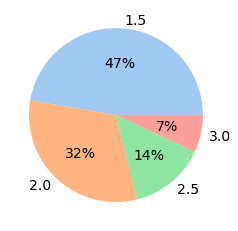

In [56]:
# v=ct_limited_open_a1_r1['SliceThickness'].tolist()
v = ct_agg['SliceThickness'].tolist()
vset = set(v)
v_manual = [1.5, 2., 2.5, 3]
eps = 0.1
counts = np.zeros(len(v_manual))
for k in v:
  for i in range(len(v_manual)):
    if abs(k-v_manual[i])<eps:
      counts[i]+=1
print(v_manual)
print(counts)
counts = counts/np.sum(counts)*100
print(counts)

#define Seaborn color palette to use
colors = sb.color_palette('pastel')

plt.pie( counts, labels = ['%.1f'%x for x in v_manual], colors = colors, autopct='%.0f%%', textprops={'fontsize': 14})


In [54]:
# v1=ct_limited_open_a1_r1['PatientSex'].tolist()
v1 = ct_agg['PatientSex'].tolist()
vset = set(v1)
vset

{'F', 'M', None}

[357.  13.  19.]
[91.77377892  3.34190231  4.88431877]
['None', 'M', 'F']


([<matplotlib.patches.Wedge at 0x7f1b756c1a00>,
 [Text(-1.063470412511457, 0.2811239614702238, 'None'),
  Text(1.0080068873964456, -0.440365887599539, 'M'),
  Text(1.0870753645525368, -0.1681283788745059, 'F')],
 [Text(-0.5800747704607946, 0.15334034262012203, '92%'),
  Text(0.5498219385798794, -0.24019957505429396, '3%'),
  Text(0.5929501988468382, -0.09170638847700321, '5%')])

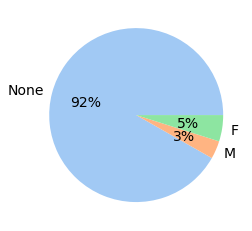

In [63]:
counts = np.zeros(len(vset))
vlist = list(vset)
for k in v1:
  counts[vlist.index(k)]+=1

print(counts)
counts = counts/np.sum(counts)*100
print(counts)

#define Seaborn color palette to use
colors = sb.color_palette('pastel')

# labels = ['F', 'M', 'None']
labels = vlist 
labels = [str(f) for f in labels]

plt.pie( counts, labels=labels, colors = colors, autopct='%.0f%%', textprops={'fontsize': 14})

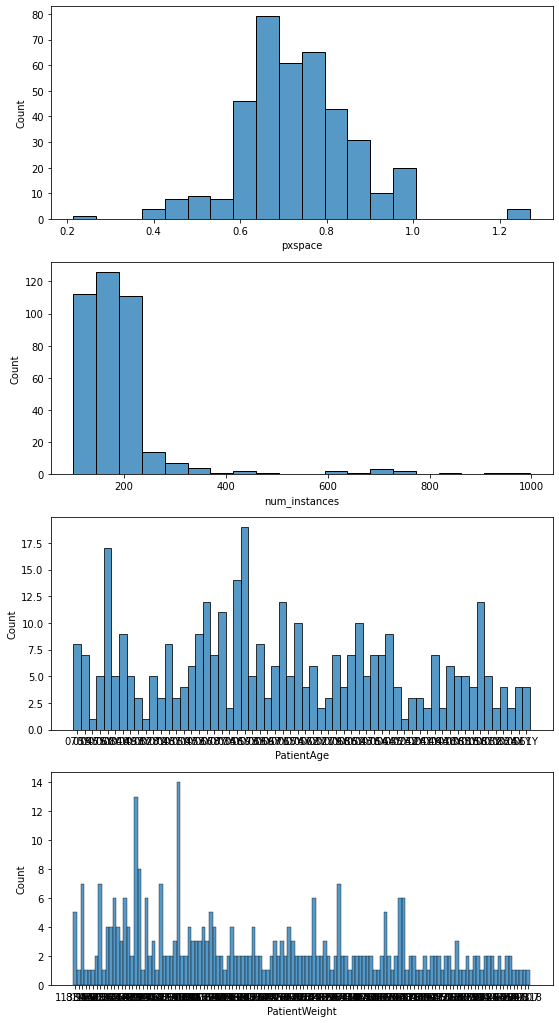

In [66]:
# plot selected

fig, ax = plt.subplots(4, 1, figsize=(9, 18))

x1 = np.random.randint(low=0, high=2, size=20)

# Slice Thickness 
#sb.histplot(ax=ax[0], x="SliceThickness", data=ct_limited_open_a1_r1)

# Slice Resolution 
sb.histplot(ax=ax[0], bins=20, x="pxspace", data=ct_agg)
#ax.set_xticks(np.arange(0, len(x1)+1, 25))

# Number of Slices
sb.histplot(ax=ax[1], bins=20, x="num_instances", data=ct_agg)
#plt.xlim(0,800)

# PatientAge
sb.histplot(ax=ax[2], x="PatientAge", bins = 20, data=ct_agg)
#ax.set_xticks(np.arange(0, len(x1)+1, 25))

# PatientWeight
sb.histplot(ax=ax[3], x="PatientWeight", bins = 20, data=ct_agg)

# BodyPartExamined
#sb.countplot(ax=ax[0], x="BodyPartExamined", data=ct_open_a1_r1)

# PatientSex
#sb.countplot(ax=ax[5], x="PatientSex", data=ct_limited_open_a1_r1)


# Radiomics plots

In [67]:
%%bigquery radiomics_features_flatness --project=bwh-midrc-rapid-res-1655321320

WITH
  flatness_series AS (
  SELECT
    *
  FROM
    # bwh-midrc-rapid-res-1655321320.midrc_dicom_us.quantitative_measurements
    bwh-midrc-rapid-res-1655321320.midrc_dicom_us.quantitative_measurements_features_dk_with_ohif
  WHERE
    Quantity.CodeMeaning = "Flatness" 
    #Quantity.CodeMeaning = "VoxelVolume"
    )
SELECT
  StudyInstanceUID,
  Value,
  CONCAT("https://idc-tester-1.web.app/projects/bwh-midrc-rapid-res-1655321320/locations/us-central1/datasets/afedorov-hc-dataset/dicomStores/dicom/study/", StudyInstanceUID) as viewer_url
FROM
  # bwh-midrc-rapid-res-1655321320.midrc_dicom_us.midrc_with_seg_sr AS dicom_all
  bwh-midrc-rapid-res-1655321320.midrc_dicom_us.midrc_with_seg_sr_dk AS dicom_all
JOIN
  flatness_series
ON
  flatness_series.SOPInstanceUID = dicom_all.SOPInstanceUID
ORDER BY
  Value DESC
  # https://idc-tester-1.web.app/projects/bwh-midrc-rapid-res-1655321320/locations/us-central1/datasets/afedorov-hc-dataset/dicomStores/dicom/study/2.16.840.1.114274.1818.47388429601053462484705357181174281372

Query is running:   0%|          |

Downloading:   0%|          |

In [68]:
radiomics_features_flatness

,StudyInstanceUID,Value,viewer_url
0,2.16.840.1.114274.1818.52535272429652296882073...,0.656000000,https://idc-tester-1.web.app/projects/bwh-midr...
1,2.16.840.1.114274.1818.52535272429652296882073...,0.655000000,https://idc-tester-1.web.app/projects/bwh-midr...
2,2.16.840.1.114274.1818.52535272429652296882073...,0.655000000,https://idc-tester-1.web.app/projects/bwh-midr...
3,2.16.840.1.114274.1818.52535272429652296882073...,0.655000000,https://idc-tester-1.web.app/projects/bwh-midr...
4,2.16.840.1.114274.1818.52535272429652296882073...,0.655000000,https://idc-tester-1.web.app/projects/bwh-midr...
...,...,...,...
745,2.16.840.1.114274.1818.50872192904791373781744...,0.052000000,https://idc-tester-1.web.app/projects/bwh-midr...
746,2.16.840.1.114274.1818.49303087573494712491626...,0.052000000,https://idc-tester-1.web.app/projects/bwh-midr...
747,2.16.840.1.114274.1818.50872192904791373781744...,0.051000000,https://idc-tester-1.web.app/projects/bwh-midr...
748,2.16.840.1.114274.1818.50872192904791373781744...,0.047000000,https://idc-tester-1.web.app/projects/bwh-midr...


In [69]:
radiomics_features_flatness.columns

Index(['StudyInstanceUID', 'Value', 'viewer_url'], dtype='object')

In [73]:
# radiomics_features_flatness['Value'] = radiomics_features['Value'].astype(float)
radiomics_features_flatness['Value'] = radiomics_features_flatness['Value'].astype(float)

# flatness = radiomics_features_flatness['Value'].tolist()
# flatness

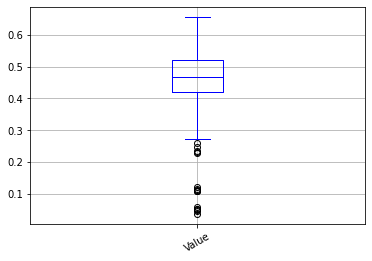

In [74]:
radiomics_features_flatness.boxplot(column="Value", grid='false', color='blue',fontsize=10, rot=30 )

In [75]:
%%bigquery radiomics_features_all --project=bwh-midrc-rapid-res-1655321320

# SELECT * FROM `bwh-midrc-rapid-res-1655321320.midrc_dicom_us.quantitative_measurements` 
SELECT * FROM `bwh-midrc-rapid-res-1655321320.midrc_dicom_us.quantitative_measurements_features_dk_with_ohif` 

#where (Quantity.CodeMeaning = "Flatness" AND 
#      Quantity.CodeMeaning = "SurfaceArea")


Query is running:   0%|          |

Downloading:   0%|          |

In [76]:
radiomics_features_all.columns

Index(['PatientID', 'SOPInstanceUID', 'SeriesDescription',
       'measurementGroup_number', 'segmentationInstanceUID',
       'segmentationSegmentNumber', 'sourceSegmentedSeriesUID',
       'trackingIdentifier', 'Quantity', 'Value', 'Units', 'finding',
       'findingSite', 'viewer_url'],
      dtype='object')

In [77]:
radiomics_features_all

,PatientID,SOPInstanceUID,SeriesDescription,measurementGroup_number,segmentationInstanceUID,segmentationSegmentNumber,sourceSegmentedSeriesUID,trackingIdentifier,Quantity,Value,Units,finding,findingSite,viewer_url
0,10000364-1265772,1.2.276.0.7230010.3.1.4.481037312.137108.16742...,lungmask_Measurements,0,1.2.276.0.7230010.3.1.4.481037312.55288.167416...,[1],2.16.840.1.114274.1818.46118491946398479151628...,Measurements group 1 - Right,"{'CodeMeaning': 'Compactness 2', 'CodeValue': ...",0.166000000,"{'CodeMeaning': 'no units', 'CodeValue': '1', ...","{'CodeMeaning': 'Organ', 'CodeValue': '1133430...","{'CodeMeaning': 'Lung', 'CodeValue': '39607008...",https://idc-tester-1.web.app/projects/bwh-midr...
1,10000364-1265772,1.2.276.0.7230010.3.1.4.481037312.137108.16742...,lungmask_Measurements,0,1.2.276.0.7230010.3.1.4.481037312.55288.167416...,[1],2.16.840.1.114274.1818.46118491946398479151628...,Measurements group 1 - Right,"{'CodeMeaning': 'Sphericity', 'CodeValue': 'QC...",0.550000000,"{'CodeMeaning': 'no units', 'CodeValue': '1', ...","{'CodeMeaning': 'Organ', 'CodeValue': '1133430...","{'CodeMeaning': 'Lung', 'CodeValue': '39607008...",https://idc-tester-1.web.app/projects/bwh-midr...
2,10000364-1265772,1.2.276.0.7230010.3.1.4.481037312.137108.16742...,lungmask_Measurements,0,1.2.276.0.7230010.3.1.4.481037312.55288.167416...,[1],2.16.840.1.114274.1818.46118491946398479151628...,Measurements group 1 - Right,"{'CodeMeaning': 'Spherical Disproportion', 'Co...",1.818000000,"{'CodeMeaning': 'no units', 'CodeValue': '1', ...","{'CodeMeaning': 'Organ', 'CodeValue': '1133430...","{'CodeMeaning': 'Lung', 'CodeValue': '39607008...",https://idc-tester-1.web.app/projects/bwh-midr...
3,10000364-1265772,1.2.276.0.7230010.3.1.4.481037312.137108.16742...,lungmask_Measurements,0,1.2.276.0.7230010.3.1.4.481037312.55288.167416...,[1],2.16.840.1.114274.1818.46118491946398479151628...,Measurements group 1 - Right,"{'CodeMeaning': 'Compactness 1', 'CodeValue': ...",0.022000000,"{'CodeMeaning': 'no units', 'CodeValue': '1', ...","{'CodeMeaning': 'Organ', 'CodeValue': '1133430...","{'CodeMeaning': 'Lung', 'CodeValue': '39607008...",https://idc-tester-1.web.app/projects/bwh-midr...
4,419639-009729,1.2.276.0.7230010.3.1.4.481037312.8709.1674257...,lungmask_Measurements,0,1.2.276.0.7230010.3.1.4.481037312.7172.1674164...,[1],1.2.826.0.1.3680043.10.474.419639.105799060738...,Measurements group 1 - Right,"{'CodeMeaning': 'Compactness 1', 'CodeValue': ...",0.018000000,"{'CodeMeaning': 'no units', 'CodeValue': '1', ...","{'CodeMeaning': 'Organ', 'CodeValue': '1133430...","{'CodeMeaning': 'Lung', 'CodeValue': '39607008...",https://idc-tester-1.web.app/projects/bwh-midr...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10495,10000364-6553682,1.2.276.0.7230010.3.1.4.481037312.53280.167435...,lungmask_Measurements,1,1.2.276.0.7230010.3.1.4.481037312.281134.16741...,[2],2.16.840.1.114274.1818.57397787504841581752943...,Measurements group 2 - Left,"{'CodeMeaning': 'Surface Area of Mesh', 'CodeV...",89594.747000000,"{'CodeMeaning': 'square millimeter', 'CodeValu...","{'CodeMeaning': 'Organ', 'CodeValue': '1133430...","{'CodeMeaning': 'Lung', 'CodeValue': '39607008...",https://idc-tester-1.web.app/projects/bwh-midr...
10496,10000364-5793210,1.2.276.0.7230010.3.1.4.481037312.56910.167435...,lungmask_Measurements,1,1.2.276.0.7230010.3.1.4.481037312.282551.16741...,[2],2.16.840.1.114274.1818.57457975148752254386654...,Measurements group 2 - Left,"{'CodeMeaning': 'Surface Area of Mesh', 'CodeV...",88364.939000000,"{'CodeMeaning': 'square millimeter', 'CodeValu...","{'CodeMeaning': 'Organ', 'CodeValue': '1133430...","{'CodeMeaning': 'Lung', 'CodeValue': '39607008...",https://idc-tester-1.web.app/projects/bwh-midr...
10497,10000364-1714989,1.2.276.0.7230010.3.1.4.481037312.58771.167435...,lungmask_Measurements,1,1.2.276.0.7230010.3.1.4.481037312.283269.16741...,[2],2.16.840.1.114274.1818.57558246195587971841446...,Measurements group 2 - Left,"{'CodeMeaning

In [ ]:
# test

In [78]:
%%bigquery radiomics_features_test --project=bwh-midrc-rapid-res-1655321320

WITH
  flatness_series AS (
  SELECT
    *
  FROM
    # bwh-midrc-rapid-res-1655321320.midrc_dicom_us.quantitative_measurements
    bwh-midrc-rapid-res-1655321320.midrc_dicom_us.quantitative_measurements_features_dk_with_ohif
  WHERE
    Quantity.CodeMeaning = "Flatness" 
    #Quantity.CodeMeaning = "VoxelVolume"
    )

SELECT
  StudyInstanceUID,
  Value,
  CONCAT("https://idc-tester-1.web.app/projects/bwh-midrc-rapid-res-1655321320/locations/us-central1/datasets/afedorov-hc-dataset/dicomStores/dicom/study/", StudyInstanceUID) as viewer_url
FROM
  # bwh-midrc-rapid-res-1655321320.midrc_dicom_us.midrc_with_seg_sr AS dicom_all
   bwh-midrc-rapid-res-1655321320.midrc_dicom_us.midrc_with_seg_sr_dk AS dicom_all
JOIN
  flatness_series
ON
  flatness_series.SOPInstanceUID = dicom_all.SOPInstanceUID
ORDER BY
  Value DESC
  # https://idc-tester-1.web.app/projects/bwh-midrc-rapid-res-1655321320/locations/us-central1/datasets/afedorov-hc-dataset/dicomStores/dicom/study/2.16.840.1.114274.1818.47388429601053462484705357181174281372

Query is running:   0%|          |

Downloading:   0%|          |

In [79]:
%%bigquery test --project=bwh-midrc-rapid-res-1655321320
# SELECT * FROM bwh-midrc-rapid-res-1655321320.midrc_dicom_us.quantitative_measurements
SELECT * FROM bwh-midrc-rapid-res-1655321320.midrc_dicom_us.quantitative_measurements_features_dk_with_ohif


Query is running:   0%|          |

Downloading:   0%|          |

In [80]:
test.Quantity[0]

{'CodeMeaning': 'Compactness 2',
 'CodeValue': 'BQWJ',
 'CodingSchemeDesignator': 'IBSI'}

In [81]:
tq_list = test['Quantity'].tolist()

In [82]:
tq_meaning = [t['CodeMeaning'] for t in tq_list]

In [83]:
test['CodeMeaning']  = tq_meaning
test['CodeMeaning']= test['CodeMeaning'].astype(str)

In [84]:
test.columns

Index(['PatientID', 'SOPInstanceUID', 'SeriesDescription',
       'measurementGroup_number', 'segmentationInstanceUID',
       'segmentationSegmentNumber', 'sourceSegmentedSeriesUID',
       'trackingIdentifier', 'Quantity', 'Value', 'Units', 'finding',
       'findingSite', 'viewer_url', 'CodeMeaning'],
      dtype='object')

In [85]:
len(set(test.sourceSegmentedSeriesUID))

375

In [86]:
len(set(test.CodeMeaning))

14

In [87]:
set(test.Value)

{Decimal('0.500000000'),
 Decimal('0.125000000'),
 Decimal('0.375000000'),
 Decimal('0.875000000'),
 Decimal('0.750000000'),
 Decimal('267.772000000'),
 Decimal('0.625000000'),
 Decimal('2326528.000000000'),
 Decimal('2.000000000'),
 Decimal('2499810.042000000'),
 Decimal('426012.000000000'),
 Decimal('1156352.917000000'),
 Decimal('299.147000000'),
 Decimal('1465176.333000000'),
 Decimal('1268582.708000000'),
 Decimal('70.625000000'),
 Decimal('2818120.000000000'),
 Decimal('140851.814000000'),
 Decimal('93.000000000'),
 Decimal('94.375000000'),
 Decimal('2022276.083000000'),
 Decimal('102.000000000'),
 Decimal('2162797.000000000'),
 Decimal('111.750000000'),
 Decimal('114.375000000'),
 Decimal('117.000000000'),
 Decimal('1540222.500000000'),
 Decimal('852096.000000000'),
 Decimal('135.750000000'),
 Decimal('137.750000000'),
 Decimal('109717.821000000'),
 Decimal('148.000000000'),
 Decimal('148.375000000'),
 Decimal('1573013.000000000'),
 Decimal('153.750000000'),
 Decimal('156.250000

In [88]:
df_total = pd.DataFrame()
for cm in set(test.CodeMeaning):
  print(cm)
  df = test[test.CodeMeaning == cm]
  df = df.groupby('sourceSegmentedSeriesUID').first()
  #print(df.Value)
  df_cm = pd.DataFrame(columns = ['sourceSegmentedSeriesUID','Value','CodeMeaning'])
  #print(df_cm)
  df_cm['sourceSegmentedSeriesUID'] = list(df.index.values)
  df_cm['Value'] = df.Value.tolist()
  df_cm['Value'] = df_cm['Value'].astype(float)
  df_cm['CodeMeaning'] = cm
  df_total = df_total.append(df_cm)
  #break

Major Axis in 3D Length
Compactness 1
Surface to Volume Ratio
Flatness
Compactness 2
Maximum 3D Diameter of a Mesh
Volume of Mesh
Minor Axis in 3D Length
Volume from Voxel Summation
Surface Area of Mesh
Sphericity
Spherical Disproportion
Least Axis in 3D Length
Elongation


In [ ]:
df_total

,sourceSegmentedSeriesUID,Value,CodeMeaning
0,1.2.826.0.1.3680043.10.474.419639.105799060738...,0.502000000,Elongation
1,1.2.826.0.1.3680043.10.474.419639.106364025147...,0.682000000,Elongation
2,1.2.826.0.1.3680043.10.474.419639.149051607502...,0.780000000,Elongation
3,1.2.826.0.1.3680043.10.474.419639.189346812051...,0.524000000,Elongation
4,1.2.826.0.1.3680043.10.474.419639.198735019931...,0.622000000,Elongation
...,...,...,...
369,2.16.840.1.114274.1818.54352507480550551635792...,116.855000000,Least Axis in 3D Length
370,2.16.840.1.114274.1818.54368937193612837791934...,89.983000000,Least Axis in 3D Length
371,2.16.840.1.114274.1818.54523201253294416831269...,129.002000000,Least Axis in 3D Length
372,2.16.840.1.114274.1818.54529809498757879121319...,85.952000000,Least Axis in 3D Length


In [ ]:
374*14

5236

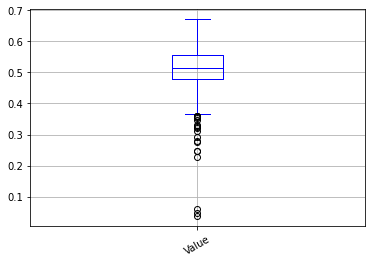

In [ ]:
df_total[df_total.CodeMeaning=='Flatness'].boxplot(column="Value", grid='false', color='blue',fontsize=10, rot=30 )

In [ ]:
df_total

,sourceSegmentedSeriesUID,Value,CodeMeaning
0,1.2.826.0.1.3680043.10.474.419639.105799060738...,0.502,Elongation
1,1.2.826.0.1.3680043.10.474.419639.106364025147...,0.682,Elongation
2,1.2.826.0.1.3680043.10.474.419639.149051607502...,0.780,Elongation
3,1.2.826.0.1.3680043.10.474.419639.189346812051...,0.524,Elongation
4,1.2.826.0.1.3680043.10.474.419639.198735019931...,0.622,Elongation
...,...,...,...
369,2.16.840.1.114274.1818.54352507480550551635792...,116.855,Least Axis in 3D Length
370,2.16.840.1.114274.1818.54368937193612837791934...,89.983,Least Axis in 3D Length
371,2.16.840.1.114274.1818.54523201253294416831269...,129.002,Least Axis in 3D Length
372,2.16.840.1.114274.1818.54529809498757879121319...,85.952,Least Axis in 3D Length


In [ ]:
df_total.columns

Index(['sourceSegmentedSeriesUID', 'Value', 'CodeMeaning'], dtype='object')

In [ ]:
col_list = ['sourceSegmentedSeriesUID'] + list(set(df_total.CodeMeaning))
df_total_by_feature = pd.DataFrame(columns=col_list)
df_total_by_feature

,sourceSegmentedSeriesUID,Elongation,Maximum 3D Diameter of a Mesh,Sphericity,Surface to Volume Ratio,Surface Area of Mesh,Spherical Disproportion,Major Axis in 3D Length,Volume from Voxel Summation,Flatness,Compactness 1,Minor Axis in 3D Length,Volume of Mesh,Compactness 2,Least Axis in 3D Length


In [ ]:
for cm in set(df_total.CodeMeaning):
  df = df_total[df_total.CodeMeaning == cm]
  df_total_by_feature.sourceSegmentedSeriesUID = list(df.index.values)
  df_total_by_feature[cm] = df.Value
  df_total_by_feature[cm] = df_total_by_feature[cm].astype(float)

In [ ]:
df_total_by_feature

,sourceSegmentedSeriesUID,Elongation,Maximum 3D Diameter of a Mesh,Sphericity,Surface to Volume Ratio,Surface Area of Mesh,Spherical Disproportion,Major Axis in 3D Length,Volume from Voxel Summation,Flatness,Compactness 1,Minor Axis in 3D Length,Volume of Mesh,Compactness 2,Least Axis in 3D Length
0,0,0.502,184.968,0.495,0.129,55626.157,2.020,191.605,429913.0,0.248,0.018,96.279,429726.042,0.121,47.540
1,1,0.682,261.851,0.599,0.067,117152.431,1.668,212.918,1749793.0,0.439,0.025,145.162,1749570.292,0.215,93.452
2,2,0.780,311.657,0.580,0.053,203823.060,1.723,256.166,3826321.0,0.487,0.023,199.769,3826057.542,0.196,124.805
3,3,0.524,240.568,0.501,0.093,104843.058,1.996,239.929,1132623.0,0.324,0.019,125.691,1132342.875,0.126,77.816
4,4,0.622,140.922,0.566,0.115,46928.178,1.766,129.972,407310.0,0.565,0.023,80.874,407151.458,0.181,73.442
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
369,369,0.955,233.758,0.558,0.067,147003.516,1.793,191.959,2207596.0,0.609,0.022,183.390,2207327.875,0.173,116.855
370,370,0.820,236.620,0.502,0.088,116880.048,1.993,187.802,1336120.0,0.479,0.019,153.936,1335710.167,0.126,89.983
371,371,0.908,245.748,0.514,0.072,161853.210,1.947,192.136,2253396.0,0.671,0.020,174.526,2253141.417,0.135,129.002
372,372,0.689,175.097,0.525,0.101,76347.230,1.906,162.914,753734.0,0.528,0.020,112.243,753553.000,0.144,85.952


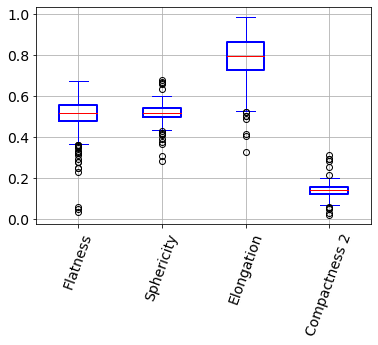

In [ ]:
boxprops = dict(linestyle='-', linewidth=2, color='blue')
medianprops = dict(linestyle='-', linewidth=1, color='red')

df_total_by_feature.boxplot( column = ['Flatness','Sphericity','Elongation', 'Compactness 2'],  color='blue',fontsize=14, rot=70, boxprops=boxprops, medianprops=medianprops)

In [ ]:
fig_fn = '\content\boxplot1.png'
plt.savefig(fig_fn)

<Figure size 432x288 with 0 Axes>

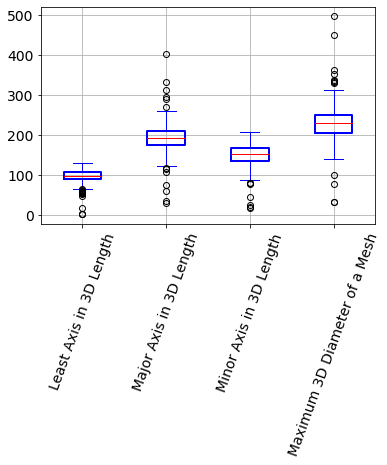

In [ ]:
boxprops = dict(linestyle='-', linewidth=2, color='blue')
medianprops = dict(linestyle='-', linewidth=1, color='red')

df_total_by_feature.boxplot( column = ['Least Axis in 3D Length','Major Axis in 3D Length','Minor Axis in 3D Length','Maximum 3D Diameter of a Mesh'], grid='false', color='blue',fontsize=14, rot=70,boxprops=boxprops, medianprops=medianprops )

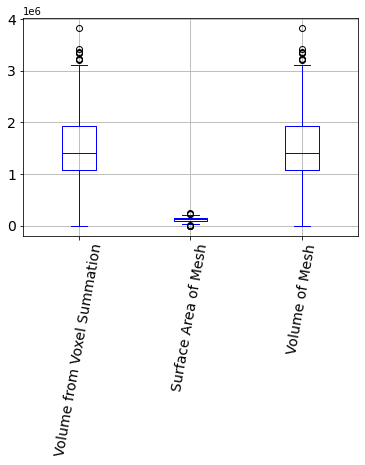

In [ ]:
df_total_by_feature.boxplot( column = ['Volume from Voxel Summation','Surface Area of Mesh','Volume of Mesh'], grid='false', color='blue',fontsize=14, rot=80 )
